<a href="https://colab.research.google.com/github/danielmachlab/CIFAR10-classifier/blob/master/dl_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load pytorch library

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=180)


# Select the device to train the CNN! "cuda:0" means the first GPU device.

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# net.to(device)

cuda:0


In [23]:
valid_ratio = 0.05
batch_size = 500
transform = transforms.Compose([ 
                                transforms.RandomApply([transforms.RandomCrop(32, padding=4)], p=0.3),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                              
                                ])

cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

num_train = int((1.0 - valid_ratio) * len(cifar_train))
num_valid = int(valid_ratio * len(cifar_train))

train_set, valid_set = torch.utils.data.dataset.random_split(cifar_train, [num_train, num_valid])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True)

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Boat', 'Truck')



Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


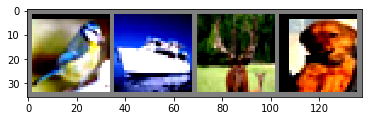

 Bird  Boat  Deer   Dog


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get iterater for loaded training images
dataiter = iter(train_loader)

# get the next batch of images and labels
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4,]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Network Definition

In [0]:
import torch.nn as nn # neural network library
import torch.nn.functional as F


class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
           

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),

            # Conv Layer block 3
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.2),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )
      

    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x



# Model Visualization

In [26]:
from torchsummary import summary
from torchvision import models

model = Network()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
summary(model, (3, 32, 32))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          36,928
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,928
             ReLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
        Dropout2d-13             [-1, 64, 8, 8]               0
           Conv2d-14            

In [27]:
from google.colab import drive
drive.mount('/content/drive')

PATH_notrig = 'drive/My Drive/School/DL/no_trig.pth'
PATH_earlystop = 'drive/My Drive/School/DL/early_stop.pth'
PATH_bestloss = 'drive/My Drive/School/DL/best_loss.pth'

def get_num_correct(predictions, labels):
  return predictions.argmax(dim=1).eq(labels).sum().item()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def print_loss(train_loss, valid_loss):
    plt.plot(train_loss, label="Train Loss")
    plt.plot(valid_loss, label="Valid Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Training Loop

35.9 seconds 	 epoch: 0 	 train loss:  1.581 	 train accuracy:  0.400 	 valid loss:  1.280 	 valid accuracy: 0.541


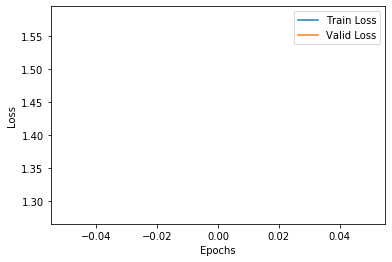

Best validation loss epoch: 0
Early stoppping epoch: -1
71.8 seconds 	 epoch: 1 	 train loss:  1.163 	 train accuracy:  0.575 	 valid loss:  1.015 	 valid accuracy: 0.643
107.5 seconds 	 epoch: 2 	 train loss:  0.955 	 train accuracy:  0.657 	 valid loss:  0.878 	 valid accuracy: 0.680
143.1 seconds 	 epoch: 3 	 train loss:  0.825 	 train accuracy:  0.707 	 valid loss:  0.751 	 valid accuracy: 0.734
178.8 seconds 	 epoch: 4 	 train loss:  0.750 	 train accuracy:  0.735 	 valid loss:  0.729 	 valid accuracy: 0.746
214.4 seconds 	 epoch: 5 	 train loss:  0.685 	 train accuracy:  0.759 	 valid loss:  0.682 	 valid accuracy: 0.762
250.0 seconds 	 epoch: 6 	 train loss:  0.642 	 train accuracy:  0.774 	 valid loss:  0.639 	 valid accuracy: 0.778
285.7 seconds 	 epoch: 7 	 train loss:  0.611 	 train accuracy:  0.787 	 valid loss:  0.660 	 valid accuracy: 0.773
321.5 seconds 	 epoch: 8 	 train loss:  0.573 	 train accuracy:  0.799 	 valid loss:  0.602 	 valid accuracy: 0.799
357.1 seconds 	 e

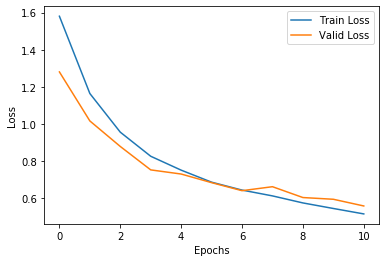

Best validation loss epoch: 10
Early stoppping epoch: -1
428.7 seconds 	 epoch: 11 	 train loss:  0.497 	 train accuracy:  0.826 	 valid loss:  0.535 	 valid accuracy: 0.817
464.3 seconds 	 epoch: 12 	 train loss:  0.477 	 train accuracy:  0.834 	 valid loss:  0.522 	 valid accuracy: 0.817
499.8 seconds 	 epoch: 13 	 train loss:  0.459 	 train accuracy:  0.842 	 valid loss:  0.550 	 valid accuracy: 0.812
535.3 seconds 	 epoch: 14 	 train loss:  0.443 	 train accuracy:  0.846 	 valid loss:  0.521 	 valid accuracy: 0.820
570.9 seconds 	 epoch: 15 	 train loss:  0.428 	 train accuracy:  0.851 	 valid loss:  0.489 	 valid accuracy: 0.826
606.5 seconds 	 epoch: 16 	 train loss:  0.413 	 train accuracy:  0.857 	 valid loss:  0.514 	 valid accuracy: 0.825
642.1 seconds 	 epoch: 17 	 train loss:  0.402 	 train accuracy:  0.860 	 valid loss:  0.501 	 valid accuracy: 0.834
early stop
677.8 seconds 	 epoch: 18 	 train loss:  0.387 	 train accuracy:  0.866 	 valid loss:  0.491 	 valid accuracy: 0.

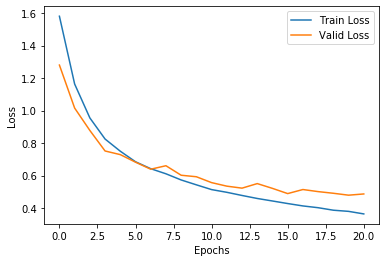

Best validation loss epoch: 19
Early stoppping epoch: 18
784.8 seconds 	 epoch: 21 	 train loss:  0.355 	 train accuracy:  0.877 	 valid loss:  0.475 	 valid accuracy: 0.833
820.4 seconds 	 epoch: 22 	 train loss:  0.350 	 train accuracy:  0.879 	 valid loss:  0.509 	 valid accuracy: 0.831
855.9 seconds 	 epoch: 23 	 train loss:  0.339 	 train accuracy:  0.882 	 valid loss:  0.461 	 valid accuracy: 0.848
891.1 seconds 	 epoch: 24 	 train loss:  0.332 	 train accuracy:  0.883 	 valid loss:  0.470 	 valid accuracy: 0.841
926.5 seconds 	 epoch: 25 	 train loss:  0.322 	 train accuracy:  0.886 	 valid loss:  0.498 	 valid accuracy: 0.838
961.7 seconds 	 epoch: 26 	 train loss:  0.318 	 train accuracy:  0.889 	 valid loss:  0.464 	 valid accuracy: 0.851
996.8 seconds 	 epoch: 27 	 train loss:  0.310 	 train accuracy:  0.891 	 valid loss:  0.463 	 valid accuracy: 0.851
1031.9 seconds 	 epoch: 28 	 train loss:  0.300 	 train accuracy:  0.894 	 valid loss:  0.495 	 valid accuracy: 0.849
1067.0

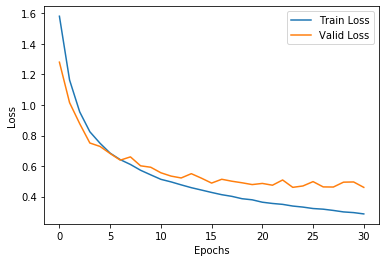

Best validation loss epoch: 30
Early stoppping epoch: 18
1137.9 seconds 	 epoch: 31 	 train loss:  0.283 	 train accuracy:  0.901 	 valid loss:  0.466 	 valid accuracy: 0.849
1173.6 seconds 	 epoch: 32 	 train loss:  0.278 	 train accuracy:  0.901 	 valid loss:  0.465 	 valid accuracy: 0.849
1209.2 seconds 	 epoch: 33 	 train loss:  0.274 	 train accuracy:  0.905 	 valid loss:  0.460 	 valid accuracy: 0.855
1244.8 seconds 	 epoch: 34 	 train loss:  0.268 	 train accuracy:  0.906 	 valid loss:  0.457 	 valid accuracy: 0.847
1280.4 seconds 	 epoch: 35 	 train loss:  0.262 	 train accuracy:  0.909 	 valid loss:  0.476 	 valid accuracy: 0.848
1316.0 seconds 	 epoch: 36 	 train loss:  0.253 	 train accuracy:  0.913 	 valid loss:  0.470 	 valid accuracy: 0.853
1351.6 seconds 	 epoch: 37 	 train loss:  0.246 	 train accuracy:  0.912 	 valid loss:  0.483 	 valid accuracy: 0.845
1387.1 seconds 	 epoch: 38 	 train loss:  0.251 	 train accuracy:  0.913 	 valid loss:  0.457 	 valid accuracy: 0.850

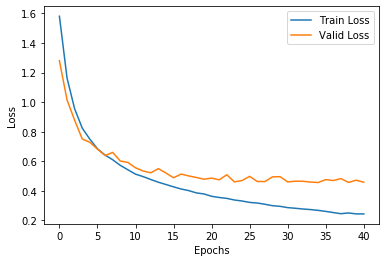

Best validation loss epoch: 34
Early stoppping epoch: 18
1493.9 seconds 	 epoch: 41 	 train loss:  0.240 	 train accuracy:  0.917 	 valid loss:  0.446 	 valid accuracy: 0.844
1529.5 seconds 	 epoch: 42 	 train loss:  0.224 	 train accuracy:  0.922 	 valid loss:  0.445 	 valid accuracy: 0.864
1565.2 seconds 	 epoch: 43 	 train loss:  0.224 	 train accuracy:  0.921 	 valid loss:  0.425 	 valid accuracy: 0.859
1600.9 seconds 	 epoch: 44 	 train loss:  0.225 	 train accuracy:  0.922 	 valid loss:  0.445 	 valid accuracy: 0.860
1636.4 seconds 	 epoch: 45 	 train loss:  0.224 	 train accuracy:  0.922 	 valid loss:  0.480 	 valid accuracy: 0.852
1672.1 seconds 	 epoch: 46 	 train loss:  0.223 	 train accuracy:  0.922 	 valid loss:  0.490 	 valid accuracy: 0.851
1707.6 seconds 	 epoch: 47 	 train loss:  0.208 	 train accuracy:  0.928 	 valid loss:  0.482 	 valid accuracy: 0.854
1743.3 seconds 	 epoch: 48 	 train loss:  0.213 	 train accuracy:  0.925 	 valid loss:  0.450 	 valid accuracy: 0.855

In [29]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

lr = 0.001
network = Network()
network.to(device)
optimizer = optim.Adam(network.parameters(), lr=lr) # parameters are weights and baises

train_loss = []
valid_loss = []
models = []
best_loss = np.float('inf')
early_epoch = -1
start_time = time.time()
stopped = False
for epoch in range(50):
    train_correct = 0
    batch_loss = []
    for batch in train_loader:
      
        images, labels = batch[0].to(device), batch[1].to(device)

        # Make Predictions, calculate loss
        predictions = network(images)
        loss = F.cross_entropy(predictions, labels)

        # Update Network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save Analytics
        batch_loss.append(loss.item())
        train_correct += get_num_correct(predictions, labels)
    
    train_loss.append(sum(batch_loss)/len(batch_loss))
    with torch.no_grad():
        batch_loss = []
        valid_correct = 0
        for batch in valid_loader:
            images, labels = batch[0].to(device), batch[1].to(device)

            predictions = network(images)
            loss = F.cross_entropy(predictions, labels)
            batch_loss.append(loss.item())
            valid_correct += get_num_correct(predictions, labels)
        
        valid_loss.append(sum(batch_loss)/len(batch_loss))
    
    # Model saving
    if valid_loss[-1] < best_loss:
        torch.save(network.state_dict(), PATH_bestloss) # Best Validation Loss
        best_loss = valid_loss[-1]
        best_epoch = epoch
    
    loss_sum = 0
    models.append(network.state_dict())
    
    for k in range(epoch, max(epoch-3, 0), -1):
        loss_sum += valid_loss[k] - valid_loss[k-1]
    if loss_sum > 0 and not stopped:
        print("early stop")
        stopped = True
        torch.save(models[k], PATH_earlystop) # Early Stopping
        early_epoch = epoch
    


    print(f"{time.time() - start_time:.1f} seconds \t epoch: {epoch} \t train loss: {train_loss[-1]: .3f} \t train accuracy: {train_correct/len(train_set): .3f} \t valid loss: {valid_loss[-1]: .3f} \t valid accuracy: {valid_correct/len(valid_set):.3f}")

    if epoch % 10 == 0:
        print_loss(train_loss, valid_loss)
        print(f"Best validation loss epoch: {best_epoch}")
        print(f"Early stoppping epoch: {early_epoch}")

torch.save(models[-1], PATH_notrig) # Early Stopping




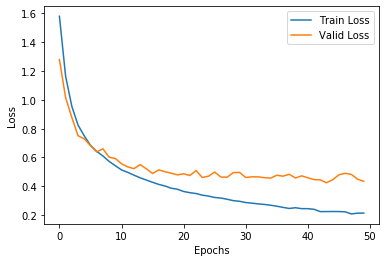

Best validation loss epoch: 43
Early stoppping epoch: 18


In [30]:
print_loss(train_loss, valid_loss)
print(f"Best validation loss epoch: {best_epoch}")
print(f"Early stoppping epoch: {early_epoch}")


# Testing Accuracy

In [31]:
# transform = transforms.Compose([transforms.ToTensor()])

cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=True)
nets = []

try:
  bestloss_net = Network()
  bestloss_net.load_state_dict(torch.load(PATH_bestloss))
  bestloss_net.to(device)
  nets.append(bestloss_net)
except FileNotFoundError:
  print(f"{PATH_bestloss} file not found")

try:
  earlystop_net = Network()
  earlystop_net.load_state_dict(torch.load(PATH_earlystop))
  earlystop_net.to(device)
  nets.append(earlystop_net)
except FileNotFoundError:
  print(f"{PATH_earlystop} file not found")

try:
  notrig_net = Network()
  notrig_net.load_state_dict(torch.load(PATH_notrig))
  notrig_net.to(device)
  nets.append(notrig_net)
except FileNotFoundError:
  print(f"{PATH_notrig} file not found")

net_names = ["bestloss_net", "earlystop_net", "notrig_net"]

for i, net in enumerate(nets, 0):
  total_correct = 0
  for batch in test_loader:
      images, labels = batch[0].to(device), batch[1].to(device)
      predictions = net(images)
  total_correct += predictions.argmax(dim=1).eq(labels).sum().item()
  print(f"Test accuracy {net_names[i]}: {total_correct/len(cifar_test)}")



Files already downloaded and verified
Test accuracy bestloss_net: 0.0419
Test accuracy earlystop_net: 0.0411
Test accuracy notrig_net: 0.0422


In [32]:
total_correct = 0
for batch in test_loader:
    images, labels = batch[0].to(device), batch[1].to(device)
    predictions = network(images)
    total_correct += predictions.argmax(dim=1).eq(labels).sum().item()

print(f"Test accuracy: {total_correct/len(cifar_test)}")

Test accuracy: 0.8519
